# Exploratory Analysis of Pitching Data

This notebook explores the pitching data to be used for developing the model.

In [1]:
%load_ext autoreload
% autoreload 2
% matplotlib inline

In [2]:
import sys
import pandas as pd
import numpy as np
import scipy
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../src/')
from utils.PitchDB import PitchDB
from preproc import features

In [3]:
db = PitchDB()
df = db.query('select * from dataset')

## Initial exploration and checks

First, only explore 2015 and 2016 data, as 2017 data is reserved for testing and final analysis only. Then, find and drop rows with NaN in critical features of the data (i.e. location data). Given the surfeit amount of the data, dropping rows with NaN is a reasonable approach

In [4]:
df = df[~df['play_guid'].str.contains('_2017_')]

In [5]:
# drop intentional walks
df = df[df['pitch_type'] != 'IN']

In [6]:
# count NaNs for each column
df.drop(['num', 'event_num', 'play_guid', 'count'], axis=1).isnull().sum()

type                     0
pitch_type               0
gameday_link             0
sz_top                   0
sz_bot                   0
px                       0
pz                       0
spin_rate             5370
spin_dir                 0
vx0                      0
vy0                      0
vz0                      0
x0                       0
y0                       0
z0                       0
pitcher                  0
pitcher_name         24589
batter                   0
batter_name          23446
b                        0
s                        0
o                        0
p_throws                 0
stand                    0
adj_sz_top               0
adj_sz_bot               0
time_from_release        0
tx_175                   1
ty_175                   1
tz_175                   1
tx_225                   1
ty_225                   1
tz_225                   1
is_strike                0
balls                    0
strikes                  0
dtype: int64

In [7]:
# drop the rows that contain NaNs in model-relevant features
df = df.dropna(subset=['tx_225', 'tz_225', 'tx_175', 'tz_175', 'spin_rate'])
print(df.shape)

(2211019, 40)


## Selected Pitchers

In the `pitchers` notebook, we reduced the data down to a selected number of pitchers. This procedure selected pitchers who a) faced more than 200 batters in 2015/2016 combined (therefore allowing each pitcher to have sufficient training data for the model) and b) were in the top 8 pitchers on their team according to batters faced and innings pitched (therefore giving each pitcher enough sample size for model evaluation and various pitching statistics). This sorting approach is arbitrary, but ensures enough data from each pitcher for modelling.

In [8]:
selected_pitchers = pd.read_csv('../data/pitcher_stats.csv')

df = df.merge(selected_pitchers[['mlb_id', 'Name']], left_on='pitcher', right_on='mlb_id')
df.shape

(1245161, 42)

## Descriptives of Input Features 

The main features for the model are:
- Ball location 225ms after release (`tx_225`, `tz_225`)
- Pitch velocity (`vy0` in mph) 
- Spin information (`spin_rate` and `spin_dir`). However, questionable as to how much weight these will be given since spin information is so difficult to perceive. One option is to divide into categories (e.g., spin rate of slow vs fast, spin direction of side vs back). 
- Count information (`balls`, `strikes`, `o`)
- Hand/Stance information (`p_throws`, `stand`)

Let's explore some of these features.

### Pitch Location

First, we'll plot some pitch location density maps for a few pitchers. Then, we'll rescale pitch location for each individual pitcher so that all pitchers are on the same scale. Thus, the model uses relative, rather than absolute, position information. We'll retain the scaling paramters of the training data to apply on the test set.

In [9]:
# mean-center each pitcher
pitchers = df.groupby('pitcher')
scale_feats = ['tx_225', 'tz_225', 'tx_175', 'tz_175', 'px', 'pz', 'x0', 'z0']
df, objs = features.scale_pitchers(df, scale_feats)

In [10]:
df.head()

,num,event_num,play_guid,count,type,pitch_type,gameday_link,sz_top,sz_bot,px,...,mlb_id,Name,scaled_tx_225,scaled_tz_225,scaled_tx_175,scaled_tz_175,scaled_px,scaled_pz,scaled_x0,scaled_z0
190389,2.0,10,7502f7a3-7a38-4762-8926-fbcfd534b86f,0-0,B,FT,gid_2015_05_20_slnmlb_nynmlb_1,3.56,1.7,-0.648,...,112526,Bartolo Colon,-0.025142,0.925283,0.032332,0.727106,-0.607813,1.582388,0.053178,0.142046
190390,2.0,13,78b1226a-637a-4678-9a30-1ae4b790d65c,1-0,S,FT,gid_2015_05_20_slnmlb_nynmlb_1,3.56,1.7,0.334,...,112526,Bartolo Colon,0.420158,0.530583,0.404532,0.446606,0.374187,0.696388,0.313178,0.186046
190391,2.0,15,a5108f8c-52cc-449d-95b8-f577f34cdc65,1-1,X,FT,gid_2015_05_20_slnmlb_nynmlb_1,3.56,1.7,0.016,...,112526,Bartolo Colon,0.192258,0.265083,0.196632,0.248606,0.056187,0.072388,0.159178,0.128046
190392,19.0,135,993600da-00e6-4ded-82a6-b5487d90a470,0-0,B,FT,gid_2015_05_20_slnmlb_nynmlb_1,3.63,1.7,0.976,...,112526,Bartolo Colon,0.783258,0.394983,0.691732,0.360006,1.016187,0.411388,0.363178,0.241046
190393,19.0,136,aae074f6-f4fa-4765-9deb-449a6e91e255,1-0,X,FT,gid_2015_05_20_slnmlb_nynmlb_1,3.56,1.7,-0.041,...,112526,Bartolo Colon,0.232658,-0.194717,0.233932,-0.151894,-0.000813,-0.594612,0.135178,-0.097954


In [11]:
# plot density plots of exemplar pitchers
stroman = df[df['pitcher_name'] == 'Marcus Stroman']
kershaw = df[df['pitcher_name'] == 'Clayton Kershaw']
scherzer = df[df['pitcher_name'] == 'Max Scherzer']
keuchel = df[df['pitcher_name'] == 'Dallas Keuchel']


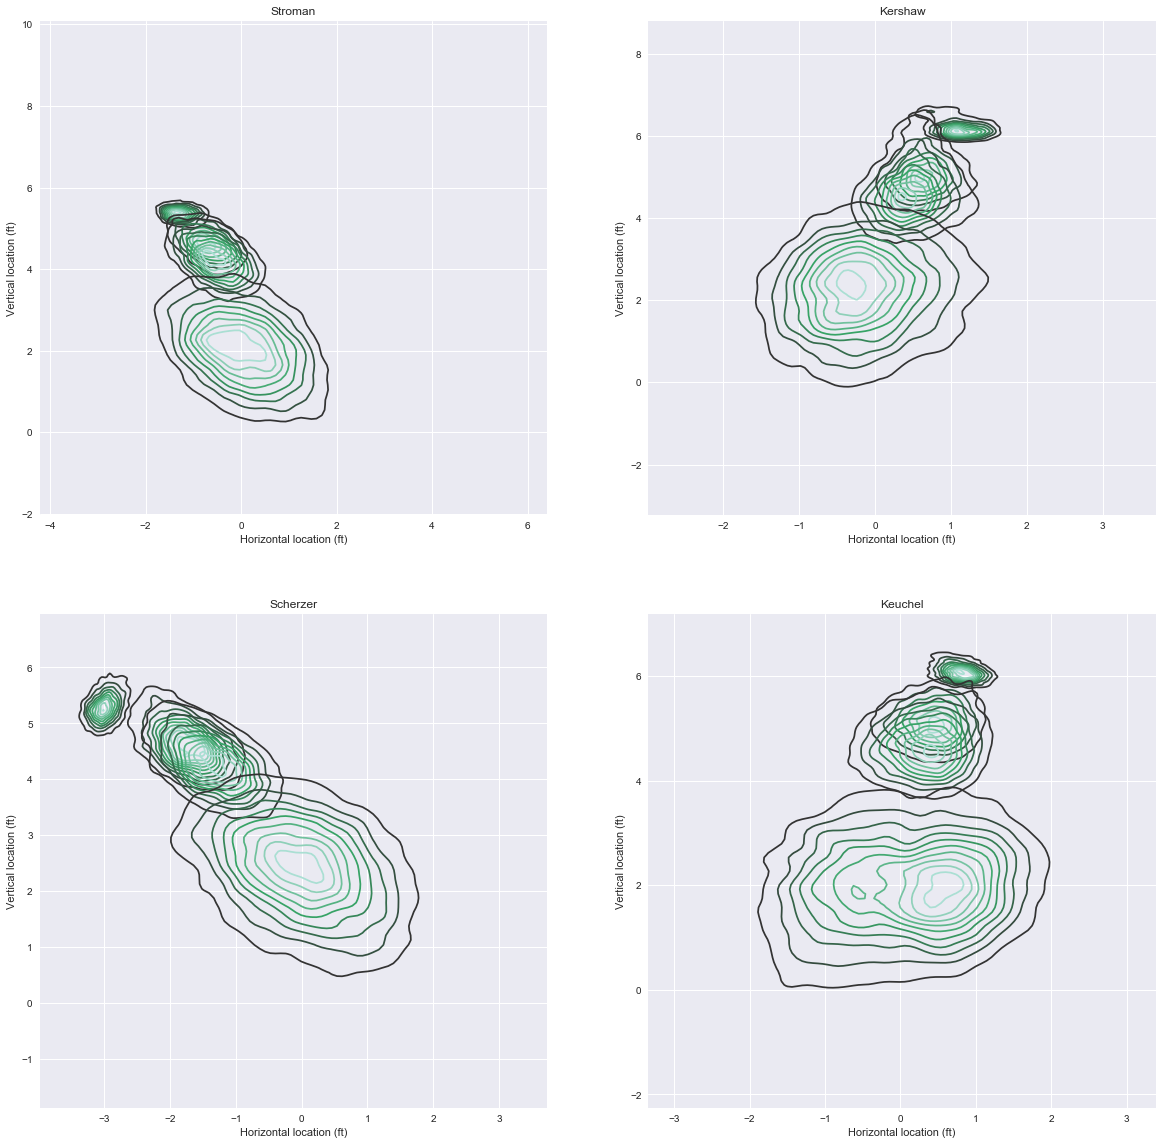

In [12]:
plt.figure(figsize=[20, 20])
pitcher_names = ['Stroman', 'Kershaw', 'Scherzer', 'Keuchel']
pitchers = [stroman, kershaw, scherzer, keuchel]
for i, j in enumerate(pitchers):
    plt.subplot(2, 2, i + 1)
    plt.title(pitcher_names[i])
    sns.kdeplot(j.x0, j.z0, shade=False)
    sns.kdeplot(j.tx_175, j.tz_175, shade=False)
    sns.kdeplot(j.tx_225, j.tz_225, shade=False)
    sns.kdeplot(j.px, j.pz, shade=False)
    plt.xlabel('Horizontal location (ft)')
    plt.ylabel('Vertical location (ft)')

Here we see the growth in distribution as the pitch travels towards the batter. Although the axes between each plot differ, we can also see how pitchers have different distributions and displacement at various points along their pitches. 

After scaling the data, we can look at the distribution of pitch location at 225ms and at the plate. We the differences in distributions between pitchers more clearly here. Note that for the modelling itself, the *position at the plate isn't used as a feature at all*; rather, it's shown only here to look at how the position variability changes from pitcher to pitcher. 

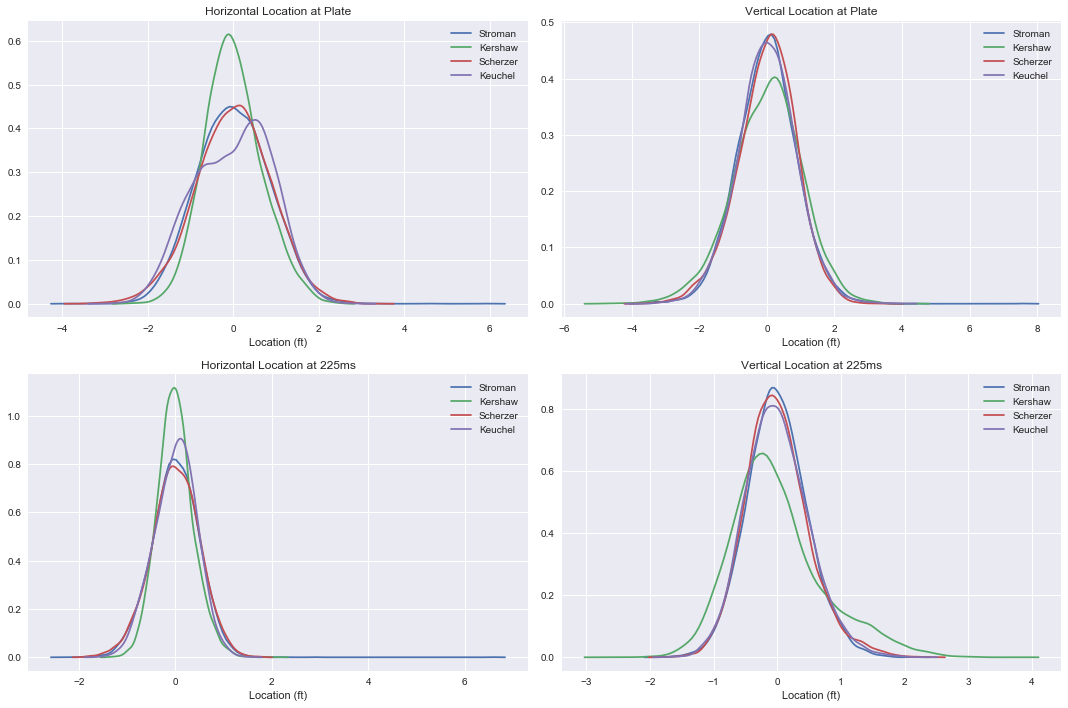

In [29]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.title('Horizontal Location at Plate')
sns.distplot(stroman.scaled_px, hist=False, label='Stroman')
sns.distplot(kershaw.scaled_px, hist=False, label='Kershaw')
sns.distplot(scherzer.scaled_px, hist=False, label='Scherzer')
sns.distplot(keuchel.scaled_px, hist=False, label='Keuchel')
plt.xlabel('Location (ft)')

plt.subplot(2, 2, 2)
plt.title('Vertical Location at Plate')
sns.distplot(stroman.scaled_pz, hist=False, label='Stroman')
sns.distplot(kershaw.scaled_pz, hist=False, label='Kershaw')
sns.distplot(scherzer.scaled_pz, hist=False, label='Scherzer')
sns.distplot(keuchel.scaled_pz, hist=False, label='Keuchel')
plt.xlabel('Location (ft)')

plt.subplot(2, 2, 3)
plt.title('Horizontal Location at 225ms')
sns.distplot(stroman.scaled_tx_225, hist=False, label='Stroman')
sns.distplot(kershaw.scaled_tx_225, hist=False, label='Kershaw')
sns.distplot(scherzer.scaled_tx_225, hist=False, label='Scherzer')
sns.distplot(keuchel.scaled_tx_225, hist=False, label='Keuchel')
plt.xlabel('Location (ft)')

plt.subplot(2, 2, 4)
plt.title('Vertical Location at 225ms')
sns.distplot(stroman.scaled_tz_225, hist=False, label='Stroman')
sns.distplot(kershaw.scaled_tz_225, hist=False, label='Kershaw')
sns.distplot(scherzer.scaled_tz_225, hist=False, label='Scherzer')
sns.distplot(keuchel.scaled_tz_225, hist=False, label='Keuchel')
plt.xlabel('Location (ft)')
plt.tight_layout()

Overall, the distributions are much narrower at 225ms than at the plate. Kershaw, among these pitchers, appears to be pretty unique in his narrow horizontal position distributions at the plate and 225ms after release. In contrast, his vertical distributions are flatter than the others, which makes sense given his breaking ball pitching style and tremendous curveball. Of note, too, is Keuchel's rather unique distribution of horizontal locations at the plate (which is shown clearly in the previous figure). 

### Pitch Velocity

Unlike location, all pitches are on the same scale and velocity is relatively invariant regardless of pitcher attributes (throwing hand, height, etc). So, we won't rescale pitch velocity. Using the same pitchers above, we can plot the velocity distributions at 50ft.

In [14]:
# first convert ft/sec to mph
pitcher_names = ['Stroman', 'Kershaw', 'Scherzer', 'Keuchel']
pitchers = dict(zip(pitcher_names, [stroman, kershaw, scherzer, keuchel]))

for k, v in pitchers.items():
    v['mph'] = features.convert_velocity(v.vy0)

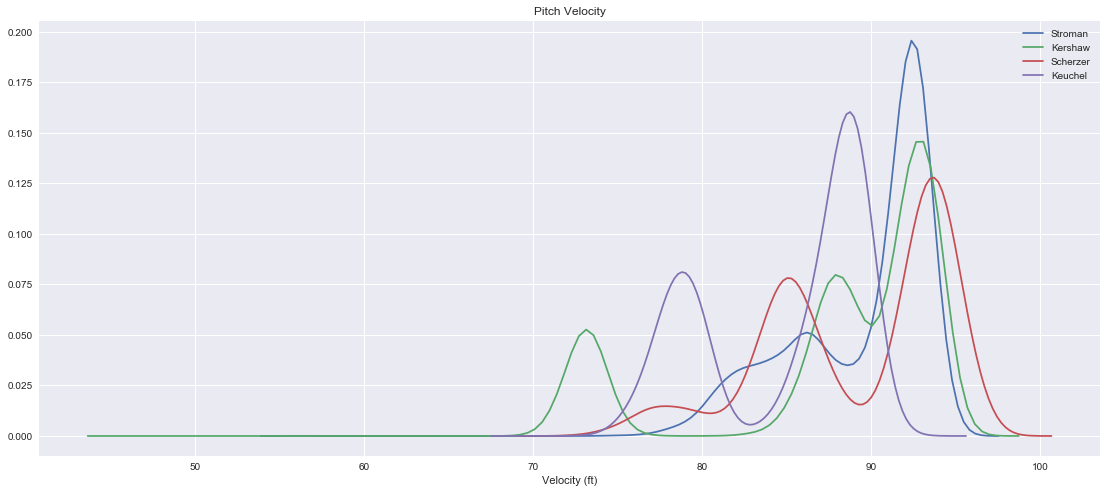

In [15]:
plt.figure(figsize=(19, 8))
plt.title('Pitch Velocity')
sns.distplot(stroman.mph, hist=False, label='Stroman')
sns.distplot(kershaw.mph, hist=False, label='Kershaw')
sns.distplot(scherzer.mph, hist=False, label='Scherzer')
sns.distplot(keuchel.mph, hist=False, label='Keuchel')
plt.xlabel('Velocity (ft)')

Of course, we wouldn't expect a unimodal distribution with pitch velocity, given that certain types of pitches have different velocities (e.g.,  fastball versus changeup). We see that Stroman's pitching tends to be dominated by faster pitches, whereas Scherzer, who's pitches tend to out-clock Stromans, is less reliable on fast pitches and tends to balance them out with pitches in the mid 80's. Although pitch type is not of interest for this particular project, I'll plot each pitcher's pitch type versus velocity:

In [16]:
for k, v in pitchers.items():
    print("{}'s pitch types: {}".format(k, sorted(np.unique(v.pitch_type).tolist())))

Stroman's pitch types: ['AB', 'CH', 'CU', 'FC', 'FF', 'FT', 'PO', 'SL']
Kershaw's pitch types: ['CH', 'CU', 'FF', 'FT', 'SL']
Scherzer's pitch types: ['CH', 'CU', 'FC', 'FF', 'FT', 'SL']
Keuchel's pitch types: ['CH', 'FC', 'FF', 'FT', 'SL']


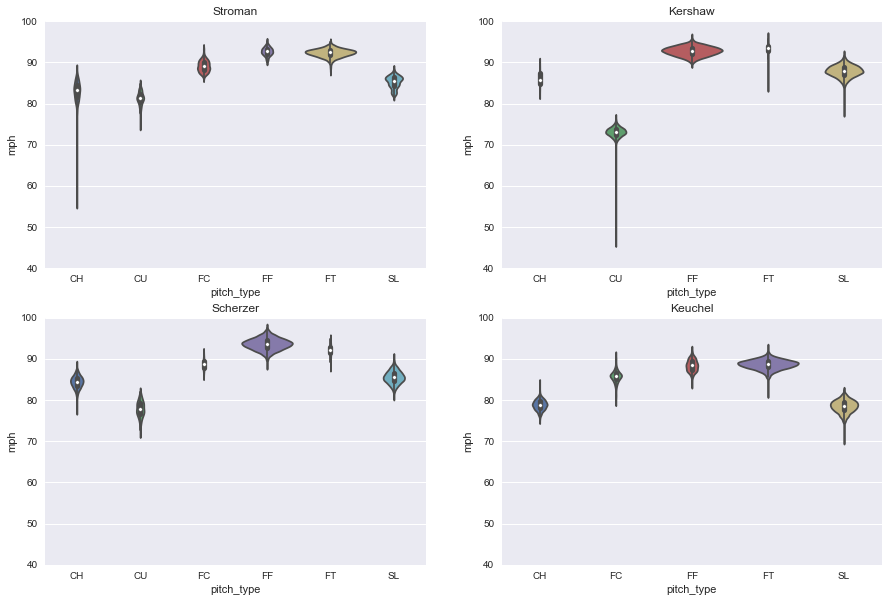

In [17]:
plt.figure(figsize=(15, 10))
for i, (k, v) in enumerate(pitchers.items()):
    plt.subplot(2, 2, i + 1)
    # drop misc pitches (PO, AB?) and sort them 
    # alphabetically along x axis
    sns.violinplot(
        x='pitch_type',
        y='mph',
        data=v[
            (v['pitch_type'] != 'AB') & 
            (v['pitch_type'] != 'PO')
        ], 
        jitter=True,
        order=sorted(
            [i for i in np.unique(v.pitch_type)
             if i not in ['AB', 'PO']]
        ),
        scale='count'
    )
    plt.title(k)
    plt.ylim(40, 100)

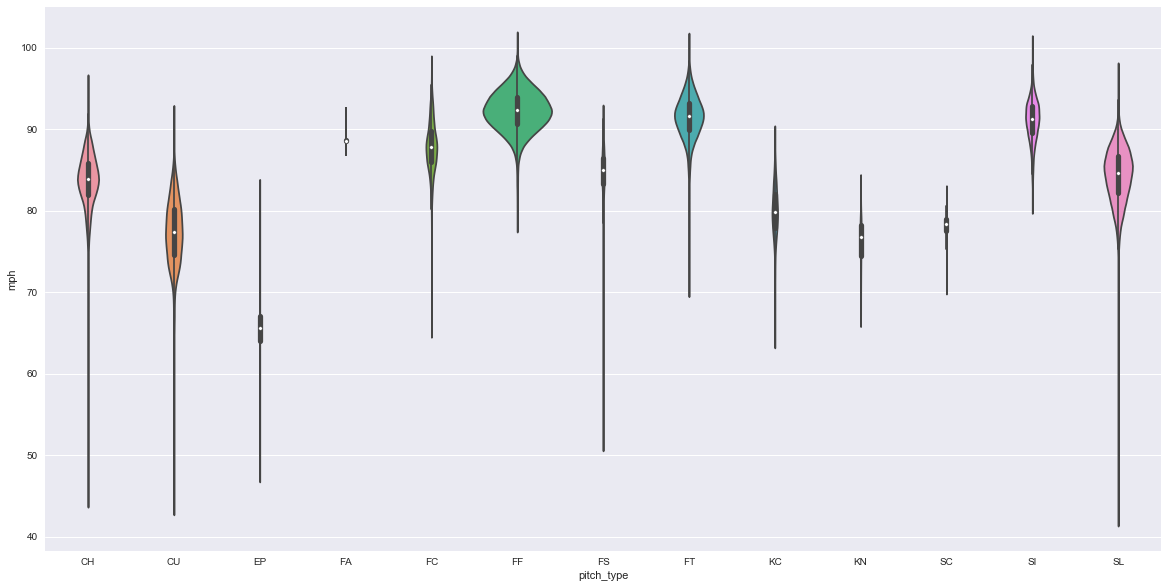

In [18]:
# looking at the entire league rather than just the subset

df['mph'] = features.convert_velocity(df.vy0)

plt.figure(figsize=(20, 10))
sns.violinplot(
    x='pitch_type',
    y='mph',
    data=df[
        (df['pitch_type'] != 'AB') & 
        (df['pitch_type'] != 'PO') &
        (df['pitch_type'] != 'UN')
    ], 
    jitter=True,
    order=sorted(
        [i for i in np.unique(df.pitch_type)
         if i not in ['AB', 'PO', 'UN']]
    ),
    scale='count'
)

So, quite clearly, various different pitches have different velocity distributions within and across pitchers. As well, we can see the overall dominance of fast-ball pitches (`FF`, `FT`, and `FC`). At the risk of stating the obvious, we can see that pitch velocity plays a critical role in differentiating pitches, which in turn plays a role in how a pitch will cross the plate. 

Of course, pitch velocity determines how far away the ball is from the plate at 225ms. Hence, the Y position of the ball at 225ms (the distance) is not included in the model. Just as proof of the near perfect correlation: 

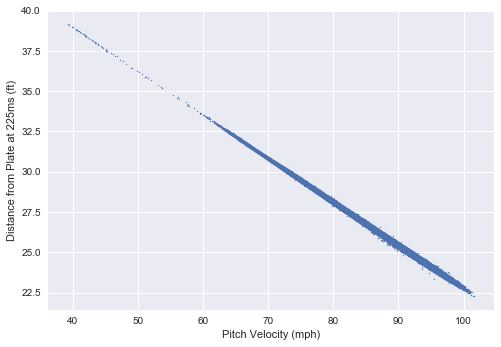

r = -0.9995, p = 0.0


In [19]:
plt.scatter(df['mph'], df['ty_225'], s=1)
plt.ylabel('Distance from Plate at 225ms (ft)')
plt.xlabel('Pitch Velocity (mph)')
plt.show()

corr = scipy.stats.pearsonr(df['mph'], df['ty_225'])
print('r = {}, p = {}'.format(np.around(corr[0], 4), corr[1]))

### Spin information

Refer to https://www.fangraphs.com/blogs/the-effects-of-spin-on-the-flight-of-a-pitch/ for weirdness with knuckleballs. And here https://www.fangraphs.com/blogs/on-rotation-part-2-the-effects-of-spin-on-pitch-outcomes/

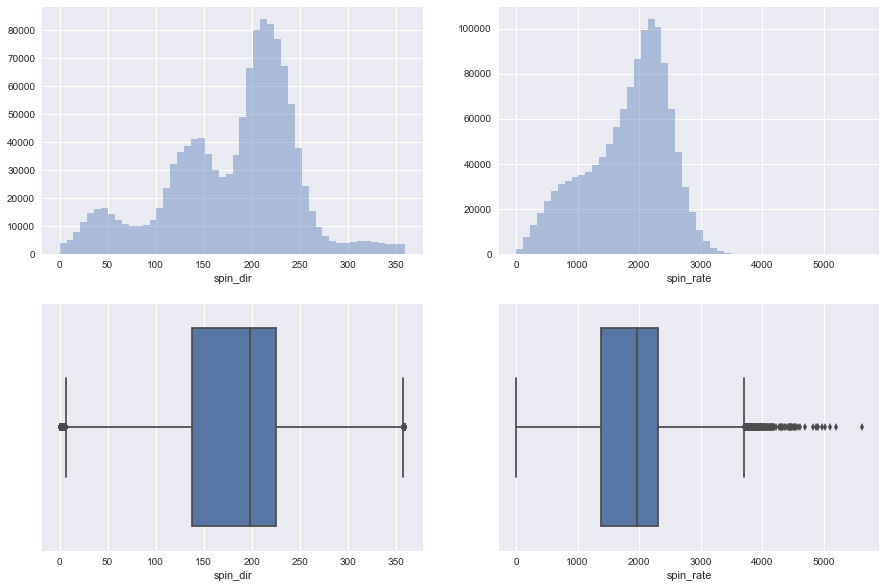

In [20]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.distplot(df['spin_dir'], kde=False)
plt.subplot(2, 2, 2)
sns.distplot(df['spin_rate'], kde=False)

# plot boxplots to see percentiles
plt.subplot(2, 2, 3)
sns.boxplot(df['spin_dir'])
plt.subplot(2, 2, 4)
sns.boxplot(df['spin_rate'])
plt.show()


In [21]:
def compute_angular_mean(x):
    # calculate in radians and convert back to deg
    return np.rad2deg(scipy.stats.circmean(np.radians(x)))

# compute circular means and SDs for each pitch type
spin_dir_mean = df.groupby(('p_throws', 'pitch_type'))['spin_dir'].aggregate(compute_angular_mean)
spin_rate_mean = df.groupby(('p_throws', 'pitch_type'))['spin_rate'].mean()
spin_mean = pd.concat([spin_dir_mean, spin_rate_mean], axis=1)

spin_mean = spin_mean.drop(['UN', 'IN', 'AB', 'PO'], level=1)

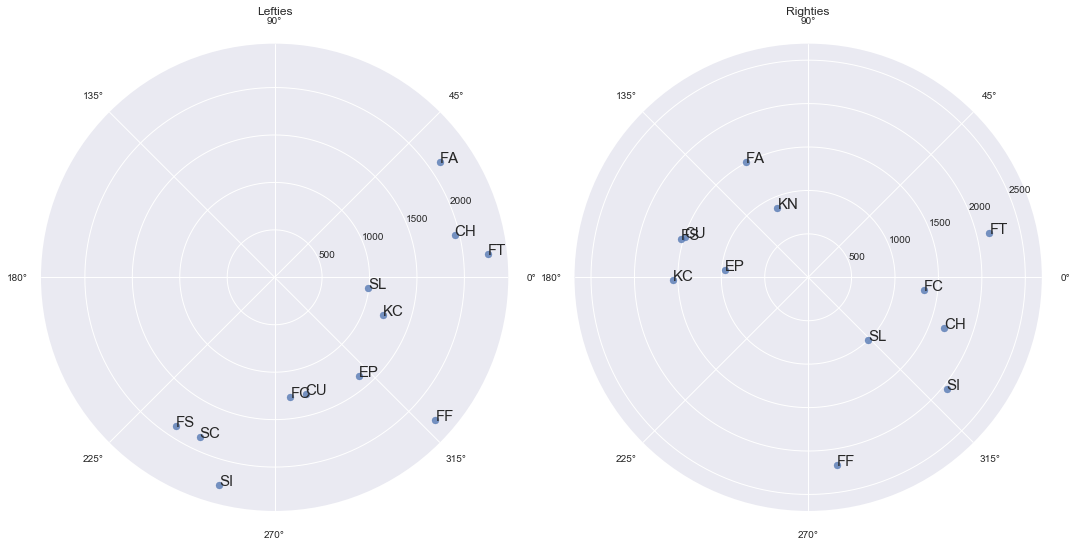

In [22]:
# make polar plots of direction vs rate
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(121, projection='polar')
# ax1.set_theta_zero_location("S")
ax1.set_title('Lefties')
ax1.scatter(spin_mean.loc['L']['spin_dir'], spin_mean.loc['L']['spin_rate'], alpha=0.75)
for i, txt in enumerate(spin_mean.loc['L'].index.values):
    ax1.annotate(txt, (spin_mean['spin_dir'].loc[('L', txt)], spin_mean['spin_rate'].loc[('L', txt)]), size=15)



ax2 = fig.add_subplot(122, projection='polar')
# ax2.set_theta_zero_location("S")
ax2.set_title('Righties')
ax2.scatter(spin_mean.loc['R']['spin_dir'], spin_mean.loc['R']['spin_rate'], alpha=0.75)
for i, txt in enumerate(spin_mean.loc['R'].index.values):
    ax2.annotate(txt, (spin_mean['spin_dir'].loc[('R', txt)], spin_mean['spin_rate'].loc[('R', txt)]), size=15)

plt.tight_layout()

...

In [23]:
df['pitcher_spin_means'] = (
    df.groupby(('pitcher', 'pitch_type'))['spin_dir']
             .transform(compute_angular_mean)
)

In [24]:
def bin_data(x, bins, labels):
    percentiles = np.percentile(x, bins)
    return pd.cut(x, percentiles, labels=labels)
    
df['spin_rate_rating'] = bin_data(df.spin_rate, [0, 25, 50, 75, 100], [0, 1, 2, 3])
df['spin_rate_rating'] = bin_data(df.spin_rate, [0, 25, 50, 75, 100], [0, 1, 2, 3])

### Count

In the dataframe, the count information is contained in the `balls`, `strikes` and `out` columns; these columns will be used in modelling. However, there is also the original `count` column, in which the aforementioned columns were parsed from, that contains a string indicating the current count. Just for convenience, I'll look the `count` column here.

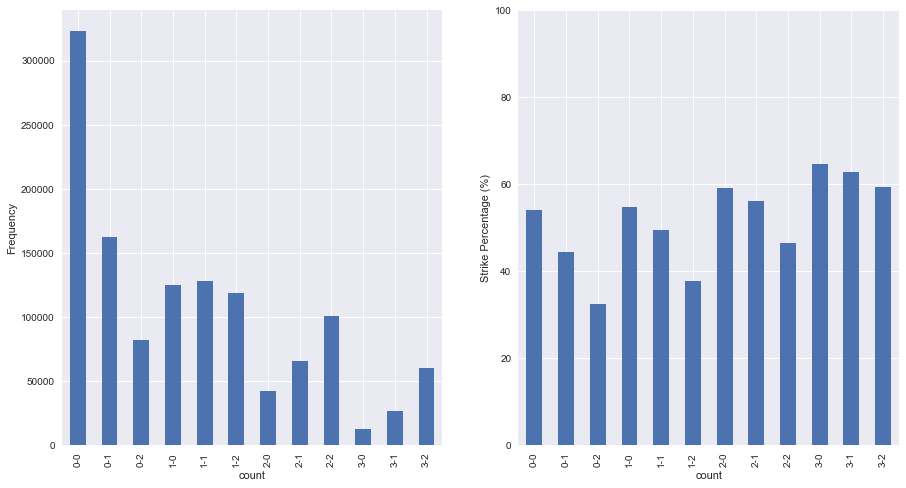

In [25]:
def strike_percent(x):
    return np.around((sum(x['is_strike']) / x.shape[0]) * 100, 2)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
df.groupby('count').size().plot(kind='bar')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
df.groupby('count').apply(strike_percent).plot(kind='bar')
plt.ylim(0, 100)
plt.ylabel('Strike Percentage (%)')

### Stance / Handedness

In [26]:
stance_funct = np.vectorize(features.label_stance_match, otypes=[str], cache=False)
df['stance_matchup'] = stance_funct(df['p_throws'], df['stand'])

df.groupby('stance_matchup').apply(strike_percent)

stance_matchup
0    48.47
1    51.06
dtype: float64

## Descriptives of Output

The output variable for the model is whether or not a given pitch is a strike (`is_strike` computed from `px`, `pz`, `sz_top`, `sz_bot`). Here, it is just a binary variable, with `1` indicating a strike. Checking the proportion of strikes:

In [27]:
print((df['is_strike'].sum() / len(df['is_strike'])) * 100)

49.643540072327994


So, almost 50% of the pitch locations at the plate are considered strikes; class imbalance doesn't seem to be an issue in this sample. 